# Dynamic graph embedding - Exploratory Data Analysis

**Libraries**

In [ ]:
import pandas as pd
import streamfig
import sknetwork as skn
import dynetworkx as dnx
import networkx as nx
import numpy as np

## Data

In [2]:
path = '/Users/simondelarue/Documents/MS_BGD-Telecom_PARIS/Stage/1_data'

Data comes from [SFHH Conference Dataset](http://www.sociopatterns.org/datasets/sfhh-conference-data-set/).

In [328]:
df = pd.read_csv(f'{path}/tij_SFHH.dat_', header=None, names=['t', 'i', 'j'], delimiter=' ') # SF2H conference
#df = pd.read_csv(f'{path}/highschool_2011.csv', header=None, delimiter='\t') # High scool interactions (Marseille, France)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70261 entries, 0 to 70260
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   t       70261 non-null  int64
 1   i       70261 non-null  int64
 2   j       70261 non-null  int64
dtypes: int64(3)
memory usage: 1.6 MB


In [46]:
df[df['t']==146820]

,t,i,j
70256,146820,1669,1754
70257,146820,1577,1616
70258,146820,1577,1518
70259,146820,1518,1616
70260,146820,1518,1655


In [81]:
nodes = list(set(df['i'].unique()).union(set(df['j'].unique())))
node_res = []
node_res_time = []
for node in nodes:
    # test on number of edges
    if df[(df['i']==node) | (df['j']==node)].shape[0] < 25:
        node_res.append(node)
    # test on length of global interaction window
    if df[(df['i']==node) | (df['j']==node)].index.max() - df[(df['i']==node) | (df['j']==node)].index.min() < 10000:
        node_res_time.append(node)
print(f'Node res      : {node_res}')
print(f'Node res time : {node_res_time}')

Node res      : [1435, 1446, 1486, 1565, 1586, 1614, 1633, 1639, 1646, 1758, 1777, 1780, 1785, 1817, 1830, 1861, 1922]
Node res time : [1436, 1484, 1639, 1646, 1682, 1780, 1785, 1817, 1861]


In [87]:
node_number = 1817
df[(df['i']==node_number) | (df['j']==node_number)]

,t,i,j
36416,61200,1587,1817
36462,61220,1587,1817
36801,61300,1587,1817
37853,61620,1587,1817
38272,61780,1587,1817
38877,62060,1587,1817
39104,62220,1587,1817
39241,62340,1587,1817
39682,62700,1651,1817
40940,64060,1689,1817


In [47]:
print(f"Nombre de participants (i) : {df['i'].nunique()}")
print(f"Nombre de participants (j) : {df['j'].nunique()}")

Nombre de participants (i) : 397
Nombre de participants (j) : 398


## Preprocessing

**Interval graph** networks are represented by a collection of edges existing over a time interval (see [*Data compression to choose a proper dynamicnetwork representation*](https://arxiv.org/pdf/2010.06885.pdf)).  

The SF2H dataset contains one entry for each 20 sec timestep interval between two vertices. Thus, it could be interesting to agregate information over the entire time interval, if 2 nodes are interacting for more than 20 seconds in a consecutive period of time.

In [145]:
sid = df[(df['i']==node_number) | (df['j']==node_number)]


start_times = [sid.iloc[0, :]['t'] - 20] 
end_times = [sid.iloc[0, :]['t']]
for cpt, (idx, row) in enumerate(sid.iloc[1:, :].iterrows()):
    if row['t'] == sid.iloc[cpt, :]['t'] + 20 and row['i'] == sid.iloc[cpt, :]['i'] and row['j'] == sid.iloc[cpt, :]['j']:
        start_times.append(sid.iloc[cpt, :]['t'] - 20) 
        end_times.append(row['t'])
    else:
        start_times.append(row['t'] - 20) 
        end_times.append(row['t'])
        
sid_cp = sid.copy().reset_index()
sid_cp['start'] = start_times
sid_cp['end'] = end_times
sid_cp = pd.DataFrame(sid_cp[['i', 'j', 'start', 'end']].groupby(['i', 'j', 'start'])['end'].max()).reset_index()
sid_cp

,i,j,start,end
0,1587,1817,61180,61220
1,1587,1817,61280,61300
2,1587,1817,61600,61620
3,1587,1817,61760,61780
4,1587,1817,62040,62060
5,1587,1817,62200,62220
6,1587,1817,62320,62340
7,1651,1817,62680,62700
8,1689,1817,64040,64060
9,1817,1819,64100,64120


In [329]:
class SF2HPreprocessor():
    
    def __init__(self, df):
        self.df = df.sort_values(['i', 'j', 't'])
        self.nodes = list(set(df['i'].unique()).union(set(df['j'].unique())))
        
    def sub_df_by_node(self, node):
        return self.df[self.df['i'] == node | self.df['j'] == node]
        
    def aggregate_edges(self):
        start_times = [self.df.iloc[0, :]['t'] - 20] 
        end_times = [self.df.iloc[0, :]['t']]
        for cpt, (idx, row) in enumerate(self.df.iloc[1:, :].iterrows()):
            if (row['t'] == self.df.iloc[cpt, :]['t'] + 20 
                and row['i'] == self.df.iloc[cpt, :]['i'] 
                and row['j'] == self.df.iloc[cpt, :]['j']):
                start_times.append(start_times[cpt]) 
                end_times.append(row['t'])
            else:
                start_times.append(row['t'] - 20) 
                end_times.append(row['t'])

        df_ag = self.df.copy().reset_index()[['i', 'j']]
        df_ag['start'] = start_times
        df_ag['end'] = end_times
        df_ag = pd.DataFrame(df_ag.groupby(['i', 'j', 'start']).max('end')).reset_index().sort_values(['start'])
        return df_ag

In [330]:
%%time

SF2H_preproc = SF2HPreprocessor(df)

df_ag = SF2H_preproc.aggregate_edges()

CPU times: user 41.4 s, sys: 352 ms, total: 41.7 s
Wall time: 43.9 s


**Save data**

In [288]:
df_ag.to_pickle(f'{path}/preprocessed_data/aggregated_data.pkl')

In [337]:
df_ag.to_csv(f'{path}/preprocessed_data/aggregated_data.txt', header=None, index=None, sep='\t', mode='w')

In [440]:
sub_df = df_ag[(df_ag['i']==1436) | (df_ag['j']==1436)]
sub_df.to_csv(f'{path}/preprocessed_data/aggregated_data_1436.txt', header=None, index=None, sep='\t', mode='w')

In [338]:
df_ag.iloc[50:70, :].to_csv(f'{path}/preprocessed_data/aggregated_data_toy.txt', header=None, index=None, sep='\t', mode='w')

In [287]:
df_ag.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26040 entries, 1100 to 11721
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   i       26040 non-null  int64
 1   j       26040 non-null  int64
 2   start   26040 non-null  int64
 3   end     26040 non-null  int64
dtypes: int64(4)
memory usage: 1017.2 KB


## Exploratory Data Analysis

* Computes metrics on graph using Arnoux et al, metrics (Common neighbors index, etc)

Build networkX graph from interactions sequence thanks to `nx.interval_graph()`.

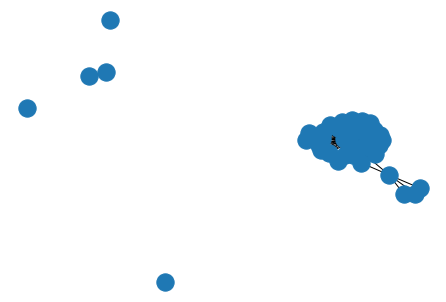

In [438]:
# Build NetworkX Graph from this data
interactions = [(row[0]+np.random.uniform(1e-5, 10**(-20)), row[1]) for row in zip(nx_df['start'], nx_df['end'])]
IG = nx.interval_graph(interactions)
nx.draw(IG, pos=nx.spring_layout(IG))

## Dynamic graphs

### Data

Data comes from [GoodRead Dataset](https://sites.google.com/eng.ucsd.edu/ucsdbookgraph/shelves)

In [223]:
%%time
good_read = pd.read_csv(f'{path}/goodreads_interactions.csv')

CPU times: user 1min 25s, sys: 55.2 s, total: 2min 20s
Wall time: 2min 49s


In [470]:
good_read.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228648342 entries, 0 to 228648341
Data columns (total 5 columns):
 #   Column       Dtype
---  ------       -----
 0   user_id      int64
 1   book_id      int64
 2   is_read      int64
 3   rating       int64
 4   is_reviewed  int64
dtypes: int64(5)
memory usage: 8.5 GB


**Build custom data**  

From the original dataset, we build smaller datasets (100 readers for example) in order to accelerate processing during research steps.

In [230]:
good_read_100_users = good_read[good_read['user_id']<100][['user_id', 'book_id', 'is_read']]
good_read_100_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42159 entries, 0 to 42158
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  42159 non-null  int64
 1   book_id  42159 non-null  int64
 2   is_read  42159 non-null  int64
dtypes: int64(3)
memory usage: 1.3 MB


In [472]:
good_read_100_users

,user_id,book_id,is_read
0,0,948,1
1,0,947,1
2,0,946,1
3,0,945,1
4,0,944,1
...,...,...,...
42154,99,27699,1
42155,99,27698,1
42156,99,27697,1
42157,99,27696,1


In [61]:
# filters only users that have read the books
sid_isread = sid[sid['is_read']==1]

In [62]:
sid_is_read.to_csv(f'{path}/goodreads_interactions_100_users_isread.csv', index=False, header=False) # 674 Ko

In [475]:
good_read_100_users.to_pickle(f'{path}/goodreads_interactions_100_users.pkl')

In [ ]:
%%time
sid_isread = pd.read_pickle(f'{path}/goodreads_interactions_100_users_isread.pkl')
sid_isread.head()

In [58]:
sid[sid['is_read']==0]

,user_id,book_id,is_read
35,0,913,0
37,0,911,0
38,0,910,0
41,0,907,0
42,0,906,0
...,...,...,...
42040,98,27597,0
42055,99,27780,0
42071,99,27766,0
42105,99,27738,0


In [238]:
from sklearn.model_selection import train_test_split

good_read_100_users_is_read = good_read[(good_read['user_id']<100)
                                            & (good_read['is_read']==1)][['user_id', 'book_id', 'is_read']]
X_train, X_test = train_test_split(good_read_100_users_is_read, random_state=42, test_size=0.2)

X_train.to_csv(f'{path}/goodreads_interactions_100_users_isread_train.csv', index=False, header=False)
X_test.to_csv(f'{path}/goodreads_interactions_100_users_isread_test.csv', index=False, header=False)

In [374]:
X_train.shape

(16127, 3)

Data for users with index in $[100;200[$, with `is_read` value equals 1.

In [224]:
good_read_100_200_users_is_read = good_read[(good_read['user_id']>=100) 
                                            & (good_read['user_id']<200) 
                                            & (good_read['is_read']==1)][['user_id', 'book_id', 'is_read']]

good_read_100_200_users_is_read.to_csv(f'{path}/goodreads_interactions_100_200_users_isread.csv', index=False, header=False)

## Spectral node embedding

1. Computes spectral node embedding for bipartite graph (using Lanczos solver)  
    - Bipartite graph is built with the first 100 readers and all the books they've read
2. Visualize impact on previous embedding when adding a new node/edge in the graph  
    - New nodes/edges are retrieved from the users with index $\in [100;200[$ in the original dataset
3. Compare metrics based on embedded space, before and after adding nodes/edges in the graph. Metrics can be :  
    - KMeans result in the embedding space (modularity metrics) ?
    - Cosine modularity of the embedding ? 
    - Top similar nodes in the embedding space ?
    - Common neighbors of top similar nodes ?

Further work :  
* Computes embedded space using `v0` parameter in Lanczos solver, initialized at previous embedding value for each iteration (instead of random initialization at every embedding space computation)

In [3]:
from IPython.display import SVG

import sknetwork as sk
from sknetwork.visualization import svg_bigraph
from scipy.sparse import csr_matrix
from sknetwork.embedding import BiSpectral
import matplotlib.pyplot as plt

### 1. Import Data

Import dataset as a **bipartite graph**. This forces to store data in **CSR format**.

In [49]:
%%time
goodReads = sk.data.load_edge_list(f'{path}/goodreads_interactions_100_users_isread_train.csv', bipartite=True, fast_format=False)

CPU times: user 72 ms, sys: 9.29 ms, total: 81.3 ms
Wall time: 85.1 ms


In [50]:
goodReads

{'biadjacency': <100x11253 sparse matrix of type '<class 'numpy.float64'>'
 	with 16127 stored elements in Compressed Sparse Row format>,
 'names': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
 'names_row': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85

In [51]:
biadjacency = goodReads.biadjacency
readers = goodReads.names
books = goodReads.names_col

# Biadjacency matrix in CSR format
biadjacency

<100x11253 sparse matrix of type '<class 'numpy.float64'>'
	with 16127 stored elements in Compressed Sparse Row format>

In [52]:
print(f'# of readers = {len(np.unique(readers))}')
print(f'# of books   = {len(np.unique(books))}')

# of readers = 100
# of books   = 11253


In [53]:
#print(biadjacency.data)
#print(biadjacency.indices)
#print(biadjacency.indptr)

### 2. Plot Data

In order to facilitate user experience, we draw only bipartite graph corresponding to users who have read less than $k$ books ($k$ defined below).

CPU times: user 68.4 ms, sys: 27.9 ms, total: 96.3 ms
Wall time: 95.9 ms


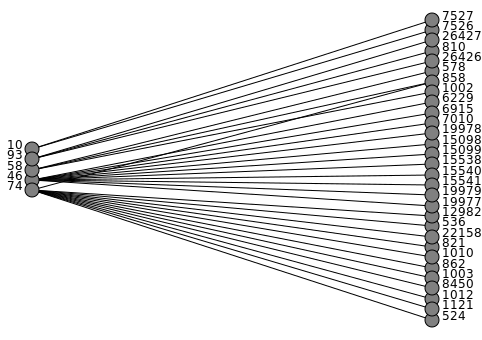

In [54]:
%%time

k = 15

goodReads_df = pd.read_csv(f'{path}/goodreads_interactions_100_users_isread_train.csv', header=None, names=['reader_id', 'book_id', 'value'])
goodReads_df.groupby('reader_id').filter(lambda x: x['value'].count() < k).to_csv(f'{path}/goodreads_interactions_few_users.csv', index=False, header=False)

goodReads_to_plot = sk.data.load_edge_list(f'{path}/goodreads_interactions_few_users.csv', bipartite=True, fast_format=False)

# Plot graph
image = svg_bigraph(goodReads_to_plot.biadjacency, names_row=goodReads_to_plot.names, names_col=goodReads_to_plot.names_col)
SVG(image)

**Optional**

In [396]:
# Plot first 2 users with the books they've read

def sample_users(biadjacency):
    sub_indices, sub_indptr, sub_data = [], [0], []
    for i in np.arange(0, 2):
        sub_indices.append(biadjacency.indices[biadjacency.indptr[i]: biadjacency.indptr[i+1]])
        sub_indptr.append(biadjacency.indptr[i+1])
        sub_data.append(biadjacency.data[biadjacency.indptr[i]: biadjacency.indptr[i+1]])
    return np.hstack(sub_indices), np.hstack(sub_indptr), np.hstack(sub_data)

sub_indices, sub_indptr, sub_data = sample_users(biadjacency)

# Build CSR matrix
sub_biadjacency = csr_matrix((sub_data, sub_indices, sub_indptr))

# Plot graph
#image = svg_bigraph(sub_biadjacency, names_row=range(sub_biadjacency.shape[0]), names_col=range((sub_biadjacency.shape[1])))
#SVG(image)

**Compute neighbors**  

Either by :
- using `books_read()` function (defined below)
- using pre-built function `sk.utils.get_neighbors()`

In [250]:
# Retrieve books read by a specific user (i.e neighbors of node u with u : id of user)

def books_read(biadjacency, user):
    return books[biadjacency.indices[biadjacency.indptr[user]:biadjacency.indptr[user+1]]]

user_id = 10
books_read_list = books_read(biadjacency, user_id)

print(f'List of books read by user {user_id} : {books_read_list}')

List of books read by user 10 : [7526 7527]


In [251]:
# Pre-built function
books[sk.utils.get_neighbors(biadjacency, user_id)]

array([7526, 7527])

### 3. Embedding

Node Spectral embedding is performed on data. For this purpose, we use the **Lanczos** solver to computes *eigenvectors* and *eigenvalues* of (normalized) Laplacian matrix.  
The dimension of the final embedding space is set to $k=20$.  

Computing *eigenvalues* and *eigenvectors* of the normalized Laplacian matrix of the graph is equivalent to computing *eigenvalues* and *eigenvectors* of the transition matrix of a random walk on the graph : 

Let $D$, the diagonal matrix of node's degress  
Let $P=D^{-1}A$, the transition matrix of a random walk on the graph
Let $L=D-A$, the Laplacian matrix of the graph

Solving 
$$
\min_{\substack{X:X^Td=0, X^TDX=I_K}} \sum_{\substack{i,j \in V}}A_{ij}||X_i - X_j||^2
$$
involves the solution of the *generalized* eigen value problem :
$$
LV = DV\Lambda, {\,} V^TDV=I
$$
with $\Lambda = diag(\lambda_1, ..., \lambda_n)$ and $V=D^{-\frac{1}{2}}U$ with $U$ the orthogonal matrix of eigenvectors of the normalized Laplacian matrix of the graph $\bar{L}=D^{-\frac{1}{2}}LD^{-\frac{1}{2}} = I - D^{-\frac{1}{2}}AD^{-\frac{1}{2}}$.

From the above solution, we can write :  

$
\begin{align*}
LV &= DV\Lambda \\
    (D-A)V &= DV\Lambda \\
    D^{-1}DV - D^{-1}AV &= V\Lambda \\
    D^{-1}DV -V\Lambda &= D^{-1}AV \\
    PV &= V(I - \Lambda) \\
\end{align*}
$

So that $V$ is also a matrix of *eigenvectors* of $P$.


In [106]:
%%time

k = 20 # Embedding dimension

# Embedding
bispectral = BiSpectral(k, normalized=False, regularization=0, scaling=0, solver='lanczos')
embedding_readers = bispectral.fit_transform(biadjacency)
embedding_books = bispectral.embedding_col_
eigvalues = bispectral.eigenvalues_

# Normalized embedding
bispectral_norm = BiSpectral(k, normalized=True, regularization=0, scaling=0, solver='lanczos')
embedding_readers_norm = bispectral_norm.fit_transform(biadjacency)
embedding_books_norm = bispectral_norm.embedding_col_
eigvalues_norm = bispectral_norm.eigenvalues_

print(f'Size of readers embedding : {embedding_readers.shape}')
print(f'Size of books embedding   : {embedding_books.shape}')

Size of readers embedding : (100, 20)
Size of books embedding   : (11253, 20)
CPU times: user 1.91 s, sys: 144 ms, total: 2.05 s
Wall time: 2.07 s


**Plot spectrum of Laplacian matrix**

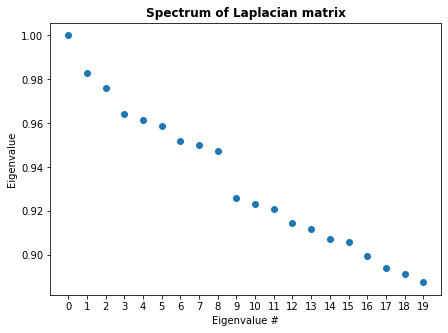

In [57]:
def print_spectrum(eigenvalues, ax, normalized=False):
    ax.scatter(range(len(eigenvalues)), eigenvalues)
    if normalized:
        ax.set_title('Spectrum of normalized Laplacian matrix', weight='bold')
    else:
        ax.set_title('Spectrum of Laplacian matrix', weight='bold')
    ax.set_xticks(np.arange(0, len(eigenvalues)))
    ax.set_xlabel('Eigenvalue #')
    ax.set_ylabel('Eigenvalue');

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
print_spectrum(eigvalues, ax)

### 4. Metrics

In order to compare different embeddings techniques, we introduce metrics that will be computed at each step/configuration set in the process.

* **Cosine-modularity** is the modularity of the embeddidng computed of on the bipartite graph
* **Top $k$ closest neighbors** is the list of nodes which are the closest in the embedding space from a reference node, considering the cosine similarity  
* **Mean Common Neighbors** is the average number of common neighbors between a reference node and its $k$ closest neighbors in the embedding space

#### 4.1 Cosine-modularity   

For bipartite graph, **cosine-modularity** $Q$ is defined as :  
$$
Q = \sum_{i,j}\biggl( \dfrac{B_{i,j}}{w} - \gamma \dfrac{w_{1,i}w_{2,j}}{w^2} \biggl) \biggl( \dfrac{1+cos(x_i, y_i)}{2} \biggl)
$$  

where :
* $w_{1,i}$, $w_{2,j}$ are the weights of nodes $i$ (row) and $j$ (column)
* $w = 1^TB1$ is the total weight of the graph  
* $x$ and $y$ the embeddings of rows and columns respectively

Source : [Scikit-network documentation](https://scikit-network.readthedocs.io/en/latest/reference/embedding.html?highlight=modularity#sknetwork.embedding.cosine_modularity)

In [59]:
from sknetwork.clustering import BiKMeans, modularity
from sknetwork.embedding import cosine_modularity
from sklearn.cluster import KMeans

In [60]:
#bikmeans = BiKMeans()
#labels = bikmeans.fit_transform(biadjacency)

In [107]:
cosine_mod = np.round(cosine_modularity(biadjacency, embedding=embedding_readers, embedding_col=embedding_books), 3)
cosine_mod_norm = np.round(cosine_modularity(biadjacency, embedding=embedding_readers_norm, embedding_col=embedding_books_norm), 3)

print(f'Cosine modularity of embedding            : {cosine_mod}')
print(f'Cosine modularity of normalized embedding : {cosine_mod_norm}')

Cosine modularity of embedding            : 0.453
Cosine modularity of normalized embedding : 0.345


**Average cosine-modularity**  

As embedding depends on a random vector initialization (cf. Lanczos algorithm), its results can vary over iterations on the same initial graph. We run 100 embeddings on the same data, and compute the **average cosine-modularity** in order to get a more stable result.

In [257]:
%%time

nb_iter = 100
k = 20 # Embedding dimension
list_cosine_mod, list_cosine_mod_norm = [], []

for i in range(nb_iter):
    
    # Embedding
    bispectral = BiSpectral(k, normalized=False, regularization=0, scaling=0, solver='lanczos')
    emb =  bispectral.fit_transform(biadjacency)
    # Normalized embedding
    bispectral_norm = BiSpectral(k, normalized=True, regularization=0, scaling=0, solver='lanczos')
    emb_norm = bispectral_norm.fit_transform(biadjacency)

    # Cosine modularity
    list_cosine_mod.append(cosine_modularity(biadjacency, embedding=emb, embedding_col=bispectral.embedding_col_))
    list_cosine_mod_norm.append(cosine_modularity(biadjacency, embedding=emb_norm, embedding_col=bispectral_norm.embedding_col_))

CPU times: user 2min 56s, sys: 15.4 s, total: 3min 12s
Wall time: 1min 31s


Average cosine modularity (100 iterations) : 
--------------------------------------------
Embedding space            : 0.444
Normalized embedding space : 0.369



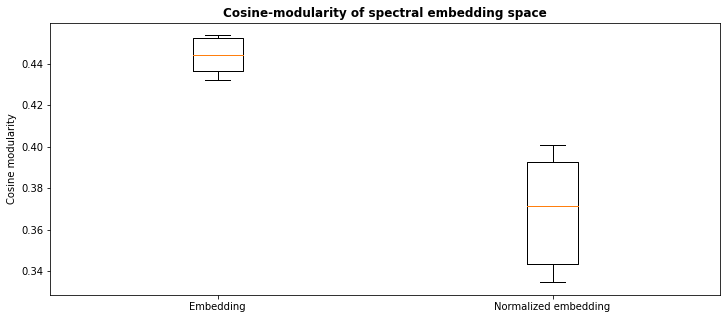

In [258]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plt.boxplot([list_cosine_mod, list_cosine_mod_norm], labels=['Embedding', 'Normalized embedding'])
plt.ylabel('Cosine modularity')
plt.title('Cosine-modularity of spectral embedding space', weight='bold');

print('Average cosine modularity (100 iterations) : \n--------------------------------------------')
print(f'Embedding space            : {np.mean(list_cosine_mod):.3f}')
print(f'Normalized embedding space : {np.mean(list_cosine_mod_norm):.3f}\n')

**Varying $k$**  

It can be interesting to observe the evolution of cosine modularity of embedding, according to the value of $k$ - the dimension of the embedding. For spectral embedding, we can assume that if $k=n$ (with $n$ the number of vertices), the embedding will capture all the structural information.

In [259]:
%%time

nb_iter = 10
list_k = np.arange(1, 30) # Embedding dimension
avg_cosine_mod, avg_cosine_mod_norm = [], []

for k in list_k:
    
    list_cosine_mod, list_cosine_mod_norm = [], []
    for i in range(nb_iter):
        # Embedding
        bispectral = BiSpectral(k, normalized=False, regularization=0, scaling=0, solver='lanczos')
        emb =  bispectral.fit_transform(biadjacency)
        # Normalized embedding
        bispectral_norm = BiSpectral(k, normalized=True, regularization=0, scaling=0, solver='lanczos')
        emb_norm = bispectral_norm.fit_transform(biadjacency)

        # Cosine modularity
        list_cosine_mod.append(cosine_modularity(biadjacency, embedding=emb, embedding_col=bispectral.embedding_col_))
        list_cosine_mod_norm.append(cosine_modularity(biadjacency, embedding=emb_norm, embedding_col=bispectral_norm.embedding_col_))
    
    avg_cosine_mod.append(np.mean(list_cosine_mod))
    avg_cosine_mod_norm.append(np.mean(list_cosine_mod_norm))

CPU times: user 7min 2s, sys: 40.1 s, total: 7min 42s
Wall time: 3min 40s


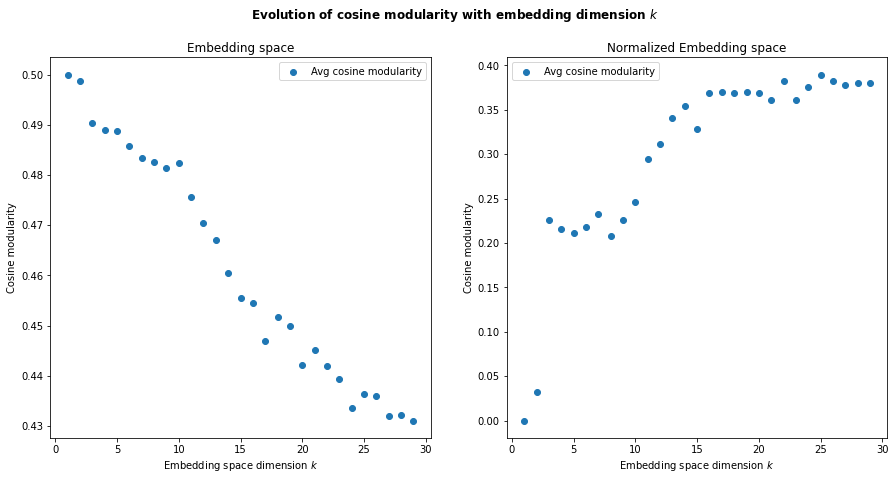

In [260]:
# Plot
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Evolution of cosine modularity with embedding dimension $k$', weight='bold')
ax[0].scatter(list_k, avg_cosine_mod, label='Avg cosine modularity')
ax[1].scatter(list_k, avg_cosine_mod_norm, label='Avg cosine modularity')
ax[0].set_title('Embedding space')
ax[1].set_title('Normalized Embedding space');
for i in range(2):
    ax[i].legend()
    ax[i].set_xlabel('Embedding space dimension $k$')
    ax[i].set_ylabel('Cosine modularity');

#### 4.2 Mean Commmon Neighbors

The idea is that close nodes in the embedding space is correlated with similar nodes in the original network, i.e nodes that have a great number of **common neighbors** for example. For a node $u$, we compute the following metric :

$$
MCN \, ratio = \dfrac{1}{k} \sum_{W}\dfrac{CN(u, max_{v \in W : |W|<=k} cossimil(x_u, x_v)}{|\mathcal{N(u)}|}
$$

with : 
- $x$ a vector of the embedding space $X$
- $CN$ the number of Common Neighbors between 2 nodes in the original graph
- $k$ the number of similar nodes to extract


**Complexity**  
- cosine similarity for every nodes : $O(nk^2)$  
    Matrix multiplication with size (n, k) * (k, n) : for each element ($n*k elements$), $k$ multiplications and $(k-1)$ additions


**Functions**

In [296]:
def rand_reader(readers):
    ''' Return a random reader from the readers list '''
    
    return np.random.randint(readers[0], readers[-1])

def common_neighbors(biadjacency, u, v):
    ''' Computes common neighbors indicator between 2 nodes in a bipartite graph.
        Parameters
        ----------
            biadjacency : CSR matrix
                Biadjacency matrix related to the bipartite graph
            u, v : Int
                Indexes (or labels) of 2 nodes in the graph 
        Output
        ------
            common neighbors between nodes u and v in bipartite graph : List<Int>. '''
    
    u_neighbors = set(sk.utils.get_neighbors(biadjacency, u))
    v_neighbors = set(sk.utils.get_neighbors(biadjacency, v))
    return u_neighbors.intersection(v_neighbors)


def closest_embedded_nodes(embedding, k, u):
    ''' Returns k closest elements from vertex u in embedding space, in term of cosine similarity. 
        Parameters
        ----------
            embedding : Matrix with shape (# vertices, embedding dimension)
                Corresponds to orthogonal matrix of eigenvectors of (normalized) Laplacian matrix, i.e embedding space
            k : Int
                Defines the number closest elements to retrieve 
            u : Int
                Index (or label) of node u in the graph
        Output
        ------
            Array of closest vertices indexes from u in embedding space, sorted from closest to less close : np.ndarray '''
    
    return np.argsort(-embedding.dot(embedding[u]))[1:k]

**Compute metrics**

In [297]:
# List top 5 readers similar to a specific reader

list_rand_readers = [rand_reader(readers) for i in range(5)]
list_readers = [22, 82, 88, 91 ,72]


print('Spectral embedding\n-------------------')
rand_readers = []
top_5_similar_readers = []
for idx, reader in enumerate(list_readers):
    top_5_similar_readers.append(readers[closest_embedded_nodes(embedding_readers, 5, reader)])

    # Common book read
    books_from_reader = set(sk.utils.get_neighbors(biadjacency, reader))
    books_from_similar_readers = [set(sk.utils.get_neighbors(biadjacency, simil_reader)) for simil_reader in top_5_similar_readers[idx]]
    nb_common_books_read = [len(books_from_reader.intersection(book_list)) for book_list in books_from_similar_readers]
    mean_nb_common_book_read = np.mean(nb_common_books_read)
    mean_ratio_common_book_read = np.mean(np.array(nb_common_books_read) / len(books_from_reader))
    
    print(f'Reader : {reader:<2} - Similar readers : {top_5_similar_readers[idx]} - Avg Common books read : {mean_nb_common_book_read:<5} - Avg ratio common book read : {mean_ratio_common_book_read:.2f}')    
    
print('\nSpectral normalized embedding\n-------------------')
rand_readers = []
top_5_similar_readers_norm = []
for idx, reader in enumerate(list_readers):
    top_5_similar_readers_norm.append(readers[closest_embedded_nodes(embedding_readers_norm, 5, reader)])

    # Common book read
    books_from_reader = set(sk.utils.get_neighbors(biadjacency, reader))
    books_from_similar_readers = [set(sk.utils.get_neighbors(biadjacency, simil_reader)) for simil_reader in top_5_similar_readers_norm[idx]]
    nb_common_books_read = [len(books_from_reader.intersection(book_list)) for book_list in books_from_similar_readers]
    mean_nb_common_book_read = np.mean(nb_common_books_read)
    mean_ratio_common_book_read = np.mean(np.array(nb_common_books_read) / len(books_from_reader))
    
    print(f'Reader : {reader:<2} - Similar readers : {top_5_similar_readers_norm[idx]} - Avg Common books read : {mean_nb_common_book_read:<5} - Avg ratio common book read : {mean_ratio_common_book_read:.2f}') 

Spectral embedding
-------------------
Reader : 22 - Similar readers : [34 42 90  3] - Avg Common books read : 19.75 - Avg ratio common book read : 0.08
Reader : 82 - Similar readers : [95 73 91 23] - Avg Common books read : 4.75  - Avg ratio common book read : 0.11
Reader : 88 - Similar readers : [72 98 50 90] - Avg Common books read : 4.75  - Avg ratio common book read : 0.05
Reader : 91 - Similar readers : [73 10 23 66] - Avg Common books read : 15.5  - Avg ratio common book read : 0.03
Reader : 72 - Similar readers : [10  9 70 13] - Avg Common books read : 7.5   - Avg ratio common book read : 0.04

Spectral normalized embedding
-------------------
Reader : 22 - Similar readers : [71 84 26 67] - Avg Common books read : 9.5   - Avg ratio common book read : 0.04
Reader : 82 - Similar readers : [63 57 12 41] - Avg Common books read : 6.25  - Avg ratio common book read : 0.15
Reader : 88 - Similar readers : [ 1 61 49 38] - Avg Common books read : 5.75  - Avg ratio common book read : 0.0

**Plot embedding space**

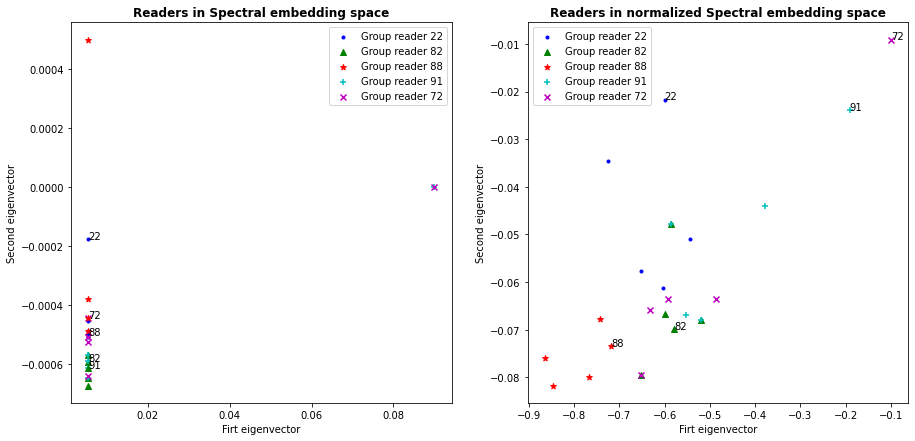

In [298]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
colors = ['b', 'g', 'r', 'c', 'm']
markers = ['.', '^', '*', '+', 'x']

# plot readers
for idx, reader in enumerate(list_readers):
    ax[0].scatter(embedding_readers[reader, 0], embedding_readers[reader, 1], color=colors[idx], marker=markers[idx], label=f'Group reader {reader}')
    ax[0].text(embedding_readers[reader, 0], embedding_readers[reader, 1], reader)
    ax[1].scatter(embedding_readers_norm[reader, 0], embedding_readers_norm[reader, 1], color=colors[idx], marker=markers[idx], label=f'Group reader {reader}')
    ax[1].text(embedding_readers_norm[reader, 0], embedding_readers_norm[reader, 1], reader)
for idx, (simil_readers, simil_readers_norm) in enumerate(zip(top_5_similar_readers, top_5_similar_readers_norm)):
    for simil_reader, simil_reader_norm in zip(simil_readers, simil_readers_norm):
        ax[0].scatter(embedding_readers[simil_reader, 0], embedding_readers[simil_reader, 1], color=colors[idx], marker=markers[idx])
        #ax[0].text(embedding_readers[simil_reader, 0], embedding_readers[simil_reader, 1], simil_reader)
        ax[1].scatter(embedding_readers_norm[simil_reader_norm, 0], embedding_readers_norm[simil_reader_norm, 1], color=colors[idx],  marker=markers[idx])
for i in range(2):
    ax[i].set_xlabel('Firt eigenvector')
    ax[i].set_ylabel('Second eigenvector')
ax[0].set_title('Readers in Spectral embedding space', weight='bold')
ax[0].legend()
ax[1].set_title('Readers in normalized Spectral embedding space', weight='bold')
ax[1].legend();

In [294]:
sk.utils.get_neighbors(biadjacency, 22)

array([  10,   13,   47,   95,  107,  118,  180,  183,  236,  276,  360,
        459,  463,  521,  522,  524,  525,  537,  555,  558,  567,  569,
        572,  575,  608,  621,  622,  624,  640,  662,  726,  728,  732,
        737,  752,  760,  764,  769,  770,  772,  776,  780,  802,  803,
        804,  805,  808,  812,  814,  817,  820,  826,  834,  837,  838,
        845,  848,  849,  867,  884,  890,  903,  933,  935,  939,  943,
        954,  955,  986, 1117, 1797, 2167, 2172, 2176, 2177, 2178, 2184,
       2195, 2196, 2269, 2284, 2523, 2568, 2869, 4123, 4288, 4342, 4345,
       4346, 4347, 4348, 4349, 4351, 4352, 4355, 4371, 4374, 4415, 4474,
       5002, 5003, 5004, 5007, 5008, 5009, 5010, 5011, 5012, 5013, 5014,
       5015, 5016, 5017, 5018, 5019, 5020, 5022, 5023, 5026, 5028, 5029,
       5030, 5031, 5032, 5034, 5038, 5039, 5040, 5041, 5042, 5043, 5045,
       5046, 5048, 5049, 5050, 5051, 5053, 5054, 5055, 5056, 5057, 5058,
       5059, 5060, 5061, 5062, 5063, 5064, 5065, 50

**Correlation between Cosine-similarity in embedding space and Common neighbors in orginial graph**

In [176]:
def CN_ratio(biadjacency, u, similar_node):

    CN = common_neighbors(biadjacency, u, similar_node)
    CN_ratio = len(set(CN)) / len(set(sk.utils.get_neighbors(biadjacency, u)))
    return CN_ratio

In [177]:
top_k = 20

# Cosine similarity between all readers pairs, filtered with only top 5 similar nodes
cossim_matrix_norm = embedding_readers_norm.dot(embedding_readers_norm.T)
top_k_similar_nodes = np.argsort(-cossim_matrix_norm)[:, :top_k]
top_k_cossim = -np.sort(-cossim_matrix_norm)[:, :top_k]
avg_top_k_cossim = np.mean(top_k_cossim, axis=1)

# Avg Common Neighbors ratio between node u and top-k similar nodes of u in the embedding space
avg_CN_ratio = []
for idx, reader in enumerate(readers):
    avg_CN_ratio.append(np.mean([CN_ratio(biadjacency, reader, similar_node) for similar_node in top_k_similar_nodes[idx]]))

In [213]:
# VERSION OPTIMISEE
# -------------------
top_k = 20

# Cosine similarity between all readers pairs, filtered with only top 5 similar nodes
cossim_matrix_norm = embedding_readers_norm.dot(embedding_readers_norm.T)
top_k_similar_nodes = np.argsort(-cossim_matrix_norm)[:, :top_k]

# Avg Common neighbors
comneighb = biadjacency.dot(biadjacency.T)
ratio_comneighb = np.diag(1/comneighb.diagonal()).dot(comneighb.todense())
avg_ratio_comneighb = [np.mean(ratio_comneighb[reader, top_k_similar_nodes[reader]], axis=1) for reader in readers]

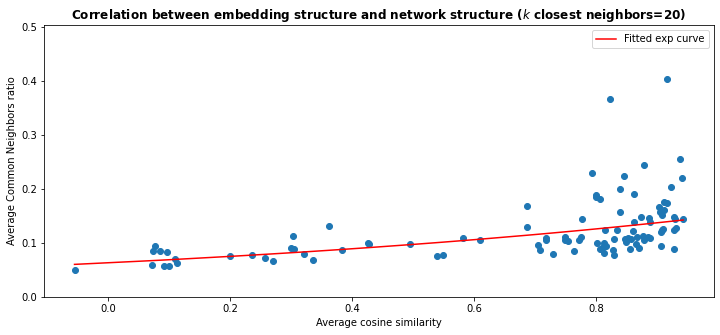

In [113]:
X = np.sort(avg_top_k_cossim)
y = np.array(avg_CN_ratio)[np.argsort(avg_top_k_cossim)]
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
plt.scatter(X, y)
plt.title(f'Correlation between embedding structure and network structure ($k$ closest neighbors={top_k})', weight='bold')
plt.xlabel('Average cosine similarity')
plt.ylabel('Average Common Neighbors ratio')
plt.ylim(0, np.max(y)+0.1);

fit = np.polyfit(np.sort(avg_top_k_cossim), np.log(np.array(avg_CN_ratio)[np.argsort(avg_top_k_cossim)]), 1)
plt.plot(np.sort(avg_top_k_cossim), np.exp(fit[1]) * np.exp(fit[0])**np.sort(avg_top_k_cossim), color='r', label='Fitted exp curve')
plt.legend();

### 5. Adding elements to graph

Now that the embedding space is computed, we can add elements into the graph, and compare metrics results for new embeddings at each step.

#### 5.1 Import new data

Each row in the DataFrame is a new link to add in the graph.

In [13]:
%%time
goodReads_df = pd.read_csv(f'{path}/goodreads_interactions_100_users_isread_train.csv', names=['reader', 'book', 'is_read'])
goodReads_new = sk.data.load_edge_list(f'{path}/goodreads_interactions_100_users_isread_test.csv', bipartite=True, fast_format=False)
goodReads_new_df = pd.read_csv(f'{path}/goodreads_interactions_100_users_isread_test.csv', names=['reader', 'book', 'is_read'])

CPU times: user 41.8 ms, sys: 33.7 ms, total: 75.5 ms
Wall time: 81.2 ms


In [276]:
goodReads_new_df.head()

,reader,book,is_read
0,80,24079,1
1,22,14671,1
2,32,17181,1
3,20,13978,1
4,19,5685,1


Let's add one element of the *test* dataset to the previous dataset (i.e *train* dataset).

In [14]:
goodReads_new_df_ex = goodReads_new_df.iloc[1:2, :]
goodReads_new_df_ex

,reader,book,is_read
1,22,14671,1


In [15]:
goodReads_df.shape

(16127, 3)

In [16]:
updated_df = pd.concat([goodReads_df, goodReads_new_df_ex], axis=0)
updated_df.shape

(16128, 3)

In [17]:
updated_df.to_csv(f'{path}/goodreads_interactions_100_users_isread_updated.csv', index=False, header=False)

For example, reader 22 never read book 14671 before as we can see below.

In [357]:
print(np.where(books==14671))
print(np.where(readers==22))

(array([5089]),)
(array([22]),)


In [360]:
# Reader 22 never read book 14671 before
np.where(books[sk.utils.get_neighbors(biadjacency, 22)]==14671)

(array([], dtype=int64),)

#### 5.2 Update Embedding

**Re-build adjacency matrix** (in CSR format)

In [114]:
updated_goodReads = sk.data.load_edge_list(f'{path}/goodreads_interactions_100_users_isread_updated.csv', bipartite=True, fast_format=False)

updated_biadjacency = updated_goodReads.biadjacency
updated_readers = updated_goodReads.names
updated_books = updated_goodReads.names_col

In [115]:
print(f'Before : {np.where(books[sk.utils.get_neighbors(biadjacency, 22)]==14671)}')
print(f'After  : {np.where(updated_books[sk.utils.get_neighbors(updated_biadjacency, 22)]==14671)}')

Before : (array([], dtype=int64),)
After  : (array([169]),)


One link has indeed been added into the graph.

**Re-build embedding**

In [116]:
k=20

# Normalized embedding
updated_bispectral_norm = BiSpectral(k, normalized=True, regularization=0, scaling=0, solver='lanczos')
updated_embedding_readers_norm = updated_bispectral_norm.fit_transform(updated_biadjacency)
updated_embedding_books_norm = updated_bispectral_norm.embedding_col_
updated_eigvalues_norm = updated_bispectral_norm.eigenvalues_

print(f'Size of readers embedding : {updated_embedding_readers_norm.shape}')
print(f'Size of books embedding   : {updated_embedding_books_norm.shape}')

Size of readers embedding : (100, 20)
Size of books embedding   : (11253, 20)


**Re-build metrics**

In [117]:
# Cosine-modularity of embedding
updated_cosine_mod_norm = np.round(cosine_modularity(updated_biadjacency, 
                                                     embedding=updated_embedding_readers_norm, 
                                                     embedding_col=updated_embedding_books_norm), 3)

print(f'Cosine modularity of normalized embedding         : {cosine_mod_norm}')
print(f'Updated Cosine modularity of normalized embedding : {updated_cosine_mod_norm}')

Cosine modularity of normalized embedding         : 0.345
Updated Cosine modularity of normalized embedding : 0.357


**Re-plot embedding**

In [118]:
# List top 5 readers similar to a specific reader
list_readers = [22, 82, 88, 91 ,72]

print('\nSpectral normalized embedding\n-------------------')
top_5_similar_readers_norm = []
for idx, reader in enumerate(list_readers):
    top_5_similar_readers_norm.append(readers[closest_embedded_nodes(embedding_readers_norm, 5, reader)])

    # Common book read
    books_from_reader = set(sk.utils.get_neighbors(biadjacency, reader))
    books_from_similar_readers = [set(sk.utils.get_neighbors(biadjacency, simil_reader)) for simil_reader in top_5_similar_readers_norm[idx]]
    nb_common_books_read = [len(books_from_reader.intersection(book_list)) for book_list in books_from_similar_readers]
    mean_nb_common_book_read = np.mean(nb_common_books_read)
    mean_ratio_common_book_read = np.mean(np.array(nb_common_books_read) / len(books_from_reader))
    
    print(f'Reader : {reader:<2} - Similar readers : {top_5_similar_readers_norm[idx]} - Avg Common books read : {mean_nb_common_book_read:<5} - Avg ratio common book read : {mean_ratio_common_book_read:.2f}') 
    
print('\nUpdated Spectral normalized embedding\n-------------------')
updated_top_5_similar_readers_norm = []
for idx, reader in enumerate(list_readers):
    updated_top_5_similar_readers_norm.append(readers[closest_embedded_nodes(updated_embedding_readers_norm, 5, reader)])

    # Common book read
    books_from_reader = set(sk.utils.get_neighbors(updated_biadjacency, reader))
    books_from_similar_readers = [set(sk.utils.get_neighbors(updated_biadjacency, simil_reader)) for simil_reader in updated_top_5_similar_readers_norm[idx]]
    nb_common_books_read = [len(books_from_reader.intersection(book_list)) for book_list in books_from_similar_readers]
    mean_nb_common_book_read = np.mean(nb_common_books_read)
    mean_ratio_common_book_read = np.mean(np.array(nb_common_books_read) / len(books_from_reader))
    
    print(f'Reader : {reader:<2} - Similar readers : {updated_top_5_similar_readers_norm[idx]} - Avg Common books read : {mean_nb_common_book_read:<5} - Avg ratio common book read : {mean_ratio_common_book_read:.2f}') 


Spectral normalized embedding
-------------------
Reader : 22 - Similar readers : [22 71 84 26 67] - Avg Common books read : 56.6  - Avg ratio common book read : 0.23
Reader : 82 - Similar readers : [82 63 57 12 41] - Avg Common books read : 13.4  - Avg ratio common book read : 0.32
Reader : 88 - Similar readers : [88  1 61 49 38] - Avg Common books read : 24.6  - Avg ratio common book read : 0.25
Reader : 91 - Similar readers : [91 23 66 41 57] - Avg Common books read : 120.2 - Avg ratio common book read : 0.24
Reader : 72 - Similar readers : [72 70 13  9 12] - Avg Common books read : 47.4  - Avg ratio common book read : 0.24

Updated Spectral normalized embedding
-------------------
Reader : 22 - Similar readers : [22 71 84 26 87] - Avg Common books read : 57.8  - Avg ratio common book read : 0.23
Reader : 82 - Similar readers : [82 63 57 12 41] - Avg Common books read : 13.4  - Avg ratio common book read : 0.32
Reader : 88 - Similar readers : [88  1 61 49 38] - Avg Common books rea

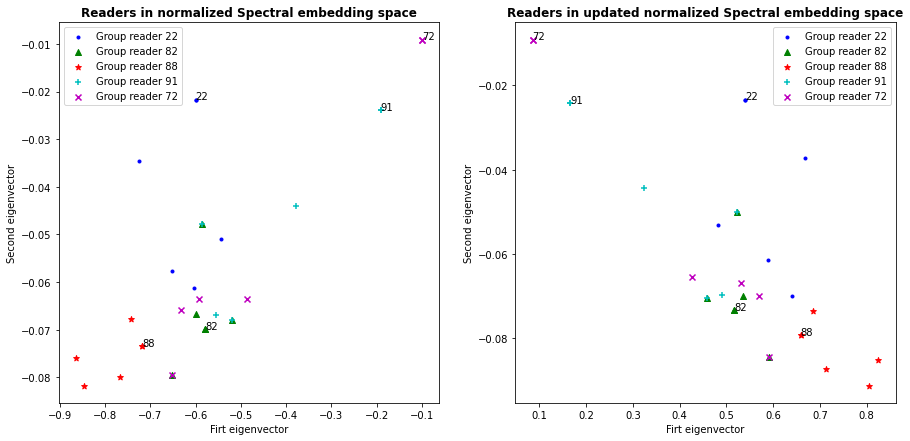

In [122]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
colors = ['b', 'g', 'r', 'c', 'm']
markers = ['.', '^', '*', '+', 'x']

# plot readers
for idx, reader in enumerate(list_readers):
    ax[0].scatter(embedding_readers_norm[reader, 0], embedding_readers_norm[reader, 1], color=colors[idx], marker=markers[idx], label=f'Group reader {reader}')
    ax[0].text(embedding_readers_norm[reader, 0], embedding_readers_norm[reader, 1], reader)
    ax[1].scatter(updated_embedding_readers_norm[reader, 0], updated_embedding_readers_norm[reader, 1], color=colors[idx], marker=markers[idx], label=f'Group reader {reader}')
    ax[1].text(updated_embedding_readers_norm[reader, 0], updated_embedding_readers_norm[reader, 1], reader)
    
for idx, (simil_readers_norm, updated_simil_readers_norm) in enumerate(zip(top_5_similar_readers_norm, updated_top_5_similar_readers_norm)):
    for simil_reader_norm, updated_simil_reader_norm in zip(simil_readers_norm, updated_simil_readers_norm):
        ax[0].scatter(embedding_readers_norm[simil_reader_norm, 0], embedding_readers_norm[simil_reader_norm, 1], color=colors[idx], marker=markers[idx])
        ax[1].scatter(updated_embedding_readers_norm[updated_simil_reader_norm, 0], updated_embedding_readers_norm[updated_simil_reader_norm, 1], color=colors[idx],  marker=markers[idx])
        
for i in range(2):
    ax[i].set_xlabel('Firt eigenvector')
    ax[i].set_ylabel('Second eigenvector')
    
ax[0].set_title('Readers in normalized Spectral embedding space', weight='bold')
ax[0].legend()
ax[1].set_title('Readers in updated normalized Spectral embedding space', weight='bold')
ax[1].legend();

**Iterating over all new nodes**

In [258]:
def add_link(df, link):
    
    updated_df = pd.concat([df, link], axis=0)
    updated_df.to_csv(f'{path}/updated_df.csv', index=False, header=False)
    return updated_df

In [280]:
import time

k = 20 # Embedding space dimension
list_cosmod = []

# - Import Data -
goodReads = sk.data.load_edge_list(f'{path}/goodreads_interactions_100_users_isread_train.csv', bipartite=True, fast_format=False)
goodReads_df = pd.read_csv(f'{path}/goodreads_interactions_100_users_isread_train.csv', names=['reader', 'book', 'is_read'])
goodReads_new_df = pd.read_csv(f'{path}/goodreads_interactions_100_users_isread_test.csv', names=['reader', 'book', 'is_read'])

# - Initial embedding -
init_biadjacency = goodReads.biadjacency
init_readers = goodReads.names
init_books = goodReads.names_col

init_bispectral_norm = BiSpectral(k, normalized=True, regularization=0, scaling=0, solver='lanczos')
init_embedding_readers_norm = init_bispectral_norm.fit_transform(init_biadjacency)
init_embedding_books_norm = init_bispectral_norm.embedding_col_

# Cosine-modularity of embedding
init_cosine_mod_norm = np.round(cosine_modularity(init_biadjacency, 
                                                     embedding=init_embedding_readers_norm, 
                                                     embedding_col=init_embedding_books_norm), 3)

list_cosmod.append(init_cosine_mod_norm) # Fill cosine similarity list



# - Initialization -
updated_df = goodReads_df.copy()

# - Add new nodes -
list_biadjacency, list_embed_readers = [], []
for i in range(goodReads_new_df.shape[0]):
    
    link = goodReads_new_df.iloc[i:i+1, :]
    updated_df = add_link(updated_df, link)
        
    # Update graph
    updated_graph = sk.data.load_edge_list(f'{path}/updated_df.csv', bipartite=True, fast_format=False)
    
    # Update Embedding
    updated_biadjacency = updated_graph.biadjacency
    updated_readers = updated_graph.names
    updated_books = updated_graph.names_col
    
    updated_bispectral_norm = BiSpectral(k, normalized=True, regularization=0, scaling=0, solver='lanczos')
    updated_embedding_readers_norm = updated_bispectral_norm.fit_transform(updated_biadjacency)
    updated_embedding_books_norm = updated_bispectral_norm.embedding_col_
    
    # Update Cosine-modularity of embedding
    updated_cosine_mod_norm = np.round(cosine_modularity(updated_biadjacency, 
                                                         embedding=updated_embedding_readers_norm, 
                                                         embedding_col=updated_embedding_books_norm), 3)
    
    list_cosmod.append(updated_cosine_mod_norm) # Fill cosine similarity list
    
    if i%100 == 0:
        list_biadjacency.append(updated_biadjacency)
        list_embed_readers.append(updated_embedding_readers_norm)

CPU times: user 1h 24min 43s, sys: 8min 55s, total: 1h 33min 38s
Wall time: 48min 45s


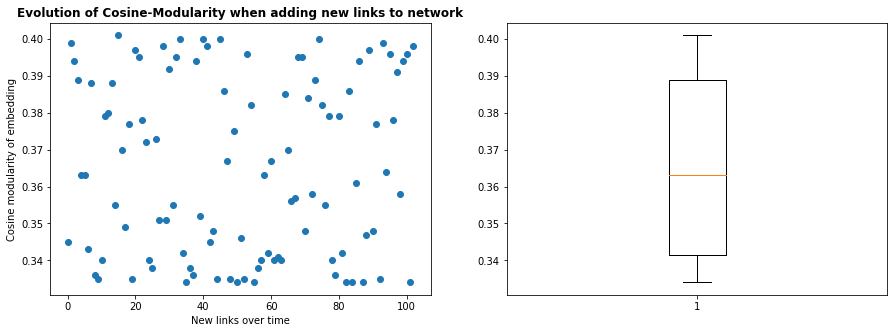

In [274]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(range(len(list_cosmod)), list_cosmod)
ax[0].set_title('Evolution of Cosine-Modularity when adding new links to network', weight='bold')
ax[0].set_xlabel('New links over time')
ax[0].set_ylabel('Cosine modularity of embedding')

ax[1].boxplot(list_cosmod);

**After 100 iterations**

In [266]:
# List top 5 readers similar to a specific reader
list_readers = [22, 82, 88, 91 ,72]

print('\nSpectral normalized embedding\n-------------------')
top_5_similar_readers_norm = []
for idx, reader in enumerate(list_readers):
    top_5_similar_readers_norm.append(readers[closest_embedded_nodes(embedding_readers_norm, 5, reader)])

    # Common book read
    books_from_reader = set(sk.utils.get_neighbors(biadjacency, reader))
    books_from_similar_readers = [set(sk.utils.get_neighbors(biadjacency, simil_reader)) for simil_reader in top_5_similar_readers_norm[idx]]
    nb_common_books_read = [len(books_from_reader.intersection(book_list)) for book_list in books_from_similar_readers]
    mean_nb_common_book_read = np.mean(nb_common_books_read)
    mean_ratio_common_book_read = np.mean(np.array(nb_common_books_read) / len(books_from_reader))
    
    print(f'Reader : {reader:<2} - Similar readers : {top_5_similar_readers_norm[idx]} - Avg Common books read : {mean_nb_common_book_read:<5} - Avg ratio common book read : {mean_ratio_common_book_read:.2f}') 
    
print('\nUpdated Spectral normalized embedding\n-------------------')
updated_top_5_similar_readers_norm = []
for idx, reader in enumerate(list_readers):
    updated_top_5_similar_readers_norm.append(updated_readers[closest_embedded_nodes(updated_embedding_readers_norm, 5, reader)])

    # Common book read
    books_from_reader = set(sk.utils.get_neighbors(updated_biadjacency, reader))
    books_from_similar_readers = [set(sk.utils.get_neighbors(updated_biadjacency, simil_reader)) for simil_reader in updated_top_5_similar_readers_norm[idx]]
    nb_common_books_read = [len(books_from_reader.intersection(book_list)) for book_list in books_from_similar_readers]
    mean_nb_common_book_read = np.mean(nb_common_books_read)
    mean_ratio_common_book_read = np.mean(np.array(nb_common_books_read) / len(books_from_reader))
    
    print(f'Reader : {reader:<2} - Similar readers : {updated_top_5_similar_readers_norm[idx]} - Avg Common books read : {mean_nb_common_book_read:<5} - Avg ratio common book read : {mean_ratio_common_book_read:.2f}') 


Spectral normalized embedding
-------------------
Reader : 22 - Similar readers : [22 71 84 26 67] - Avg Common books read : 56.6  - Avg ratio common book read : 0.23
Reader : 82 - Similar readers : [82 63 57 12 41] - Avg Common books read : 13.4  - Avg ratio common book read : 0.32
Reader : 88 - Similar readers : [88  1 61 49 38] - Avg Common books read : 24.6  - Avg ratio common book read : 0.25
Reader : 91 - Similar readers : [91 23 66 41 57] - Avg Common books read : 120.2 - Avg ratio common book read : 0.24
Reader : 72 - Similar readers : [72 70 13  9 12] - Avg Common books read : 47.4  - Avg ratio common book read : 0.24

Updated Spectral normalized embedding
-------------------
Reader : 22 - Similar readers : [22 71 84 26 87] - Avg Common books read : 58.0  - Avg ratio common book read : 0.23
Reader : 82 - Similar readers : [82 63 57 12 41] - Avg Common books read : 14.2  - Avg ratio common book read : 0.33
Reader : 88 - Similar readers : [88  1 61 49 38] - Avg Common books rea

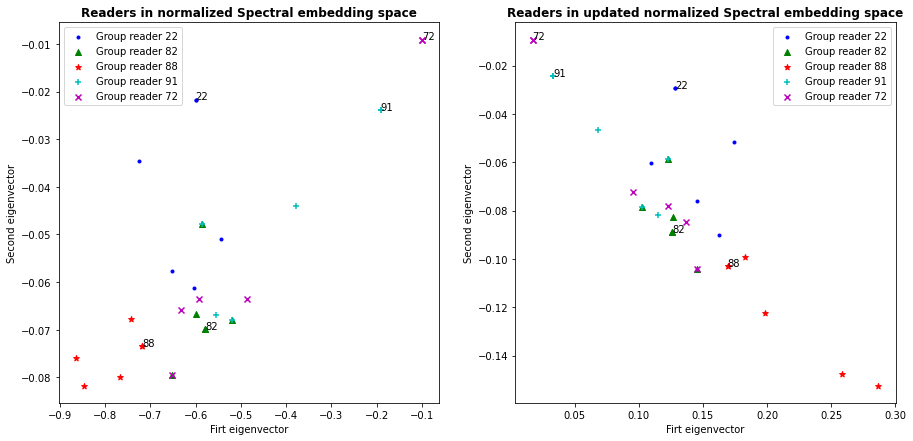

In [275]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
colors = ['b', 'g', 'r', 'c', 'm']
markers = ['.', '^', '*', '+', 'x']

# plot readers
for idx, reader in enumerate(list_readers):
    ax[0].scatter(embedding_readers_norm[reader, 0], embedding_readers_norm[reader, 1], color=colors[idx], marker=markers[idx], label=f'Group reader {reader}')
    ax[0].text(embedding_readers_norm[reader, 0], embedding_readers_norm[reader, 1], reader)
    ax[1].scatter(updated_embedding_readers_norm[reader, 0], updated_embedding_readers_norm[reader, 1], color=colors[idx], marker=markers[idx], label=f'Group reader {reader}')
    ax[1].text(updated_embedding_readers_norm[reader, 0], updated_embedding_readers_norm[reader, 1], reader)
    
for idx, (simil_readers_norm, updated_simil_readers_norm) in enumerate(zip(top_5_similar_readers_norm, updated_top_5_similar_readers_norm)):
    for simil_reader_norm, updated_simil_reader_norm in zip(simil_readers_norm, updated_simil_readers_norm):
        ax[0].scatter(embedding_readers_norm[simil_reader_norm, 0], embedding_readers_norm[simil_reader_norm, 1], color=colors[idx], marker=markers[idx])
        ax[1].scatter(updated_embedding_readers_norm[updated_simil_reader_norm, 0], updated_embedding_readers_norm[updated_simil_reader_norm, 1], color=colors[idx],  marker=markers[idx])
        
for i in range(2):
    ax[i].set_xlabel('Firt eigenvector')
    ax[i].set_ylabel('Second eigenvector')
    
ax[0].set_title('Readers in normalized Spectral embedding space', weight='bold')
ax[0].legend()
ax[1].set_title('Readers in updated normalized Spectral embedding space', weight='bold')
ax[1].legend();

**After all iterations**


Spectral normalized embedding
-------------------
Reader : 22 - Similar readers : [22 71 84 26 67] - Avg Common books read : 56.6  - Avg ratio common book read : 0.23
Reader : 82 - Similar readers : [82 63 57 12 41] - Avg Common books read : 13.4  - Avg ratio common book read : 0.32
Reader : 88 - Similar readers : [88  1 61 49 38] - Avg Common books read : 24.6  - Avg ratio common book read : 0.25
Reader : 91 - Similar readers : [91 23 66 41 57] - Avg Common books read : 120.2 - Avg ratio common book read : 0.24
Reader : 72 - Similar readers : [72 70 13  9 12] - Avg Common books read : 47.4  - Avg ratio common book read : 0.24

Updated Spectral normalized embedding
-------------------
Reader : 22 - Similar readers : [22 84 87  4  7] - Avg Common books read : 74.8  - Avg ratio common book read : 0.25
Reader : 82 - Similar readers : [82 29 63 41 66] - Avg Common books read : 25.8  - Avg ratio common book read : 0.42
Reader : 88 - Similar readers : [88 49 52 61 38] - Avg Common books rea

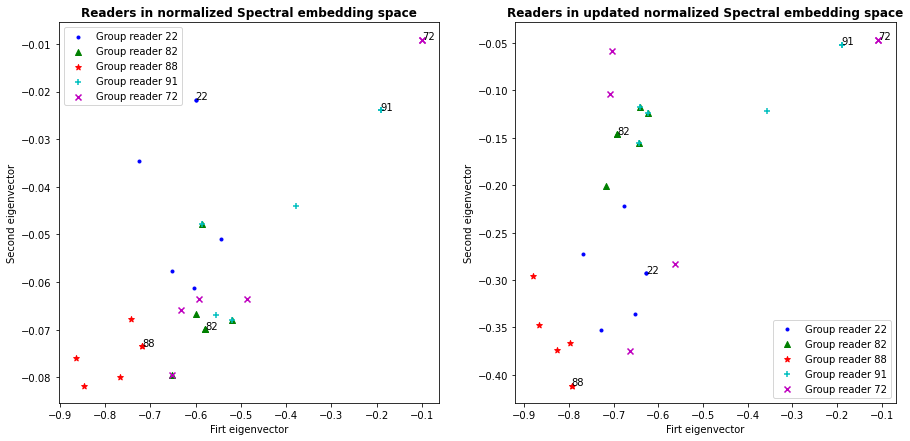

In [288]:
# List top 5 readers similar to a specific reader
list_readers = [22, 82, 88, 91 ,72]

print('\nSpectral normalized embedding\n-------------------')
top_5_similar_readers_norm = []
for idx, reader in enumerate(list_readers):
    top_5_similar_readers_norm.append(readers[closest_embedded_nodes(embedding_readers_norm, 5, reader)])

    # Common book read
    books_from_reader = set(sk.utils.get_neighbors(biadjacency, reader))
    books_from_similar_readers = [set(sk.utils.get_neighbors(biadjacency, simil_reader)) for simil_reader in top_5_similar_readers_norm[idx]]
    nb_common_books_read = [len(books_from_reader.intersection(book_list)) for book_list in books_from_similar_readers]
    mean_nb_common_book_read = np.mean(nb_common_books_read)
    mean_ratio_common_book_read = np.mean(np.array(nb_common_books_read) / len(books_from_reader))
    
    print(f'Reader : {reader:<2} - Similar readers : {top_5_similar_readers_norm[idx]} - Avg Common books read : {mean_nb_common_book_read:<5} - Avg ratio common book read : {mean_ratio_common_book_read:.2f}') 
    
print('\nUpdated Spectral normalized embedding\n-------------------')
updated_top_5_similar_readers_norm = []
for idx, reader in enumerate(list_readers):
    updated_top_5_similar_readers_norm.append(updated_readers[closest_embedded_nodes(updated_embedding_readers_norm, 5, reader)])

    # Common book read
    books_from_reader = set(sk.utils.get_neighbors(updated_biadjacency, reader))
    books_from_similar_readers = [set(sk.utils.get_neighbors(updated_biadjacency, simil_reader)) for simil_reader in updated_top_5_similar_readers_norm[idx]]
    nb_common_books_read = [len(books_from_reader.intersection(book_list)) for book_list in books_from_similar_readers]
    mean_nb_common_book_read = np.mean(nb_common_books_read)
    mean_ratio_common_book_read = np.mean(np.array(nb_common_books_read) / len(books_from_reader))
    
    print(f'Reader : {reader:<2} - Similar readers : {updated_top_5_similar_readers_norm[idx]} - Avg Common books read : {mean_nb_common_book_read:<5} - Avg ratio common book read : {mean_ratio_common_book_read:.2f}') 
    
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
colors = ['b', 'g', 'r', 'c', 'm']
markers = ['.', '^', '*', '+', 'x']

# plot readers
for idx, reader in enumerate(list_readers):
    ax[0].scatter(embedding_readers_norm[reader, 0], embedding_readers_norm[reader, 1], color=colors[idx], marker=markers[idx], label=f'Group reader {reader}')
    ax[0].text(embedding_readers_norm[reader, 0], embedding_readers_norm[reader, 1], reader)
    ax[1].scatter(updated_embedding_readers_norm[reader, 0], updated_embedding_readers_norm[reader, 1], color=colors[idx], marker=markers[idx], label=f'Group reader {reader}')
    ax[1].text(updated_embedding_readers_norm[reader, 0], updated_embedding_readers_norm[reader, 1], reader)
    
for idx, (simil_readers_norm, updated_simil_readers_norm) in enumerate(zip(top_5_similar_readers_norm, updated_top_5_similar_readers_norm)):
    for simil_reader_norm, updated_simil_reader_norm in zip(simil_readers_norm, updated_simil_readers_norm):
        ax[0].scatter(embedding_readers_norm[simil_reader_norm, 0], embedding_readers_norm[simil_reader_norm, 1], color=colors[idx], marker=markers[idx])
        ax[1].scatter(updated_embedding_readers_norm[updated_simil_reader_norm, 0], updated_embedding_readers_norm[updated_simil_reader_norm, 1], color=colors[idx],  marker=markers[idx])
        
for i in range(2):
    ax[i].set_xlabel('Firt eigenvector')
    ax[i].set_ylabel('Second eigenvector')
    
ax[0].set_title('Readers in normalized Spectral embedding space', weight='bold')
ax[0].legend()
ax[1].set_title('Readers in updated normalized Spectral embedding space', weight='bold')
ax[1].legend();

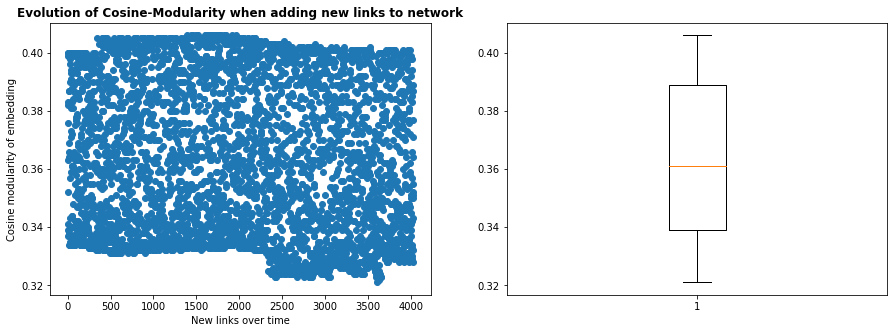

In [281]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].scatter(range(len(list_cosmod)), list_cosmod)
ax[0].set_title('Evolution of Cosine-Modularity when adding new links to network', weight='bold')
ax[0].set_xlabel('New links over time')
ax[0].set_ylabel('Cosine modularity of embedding')

ax[1].boxplot(list_cosmod);

**Modifying Lanczos**

In [408]:
import scipy
np.set_printoptions(suppress=True)
rng = np.random.default_rng()

X = rng.random((1000, 1000)) - 0.5
X = np.dot(X, X.T) 
X1 = rng.random((1000, 1000)) - 0.5
X1 = np.dot(X1, X1.T) 

v0 = np.random.rand(10, 100)
#v1 = np.random_state.rand(X.shape[0])
print(f"v0\'s shape : {v0.shape}")

eigval, eigvect = scipy.sparse.linalg.eigsh(X, 6, which='LA', v0=None)
print(f'Eigenvalues : {eigval}, {eigval.reshape(-1, 1).shape}')
print(f'Eigenvectors : {eigvect[0]}')

eigval1, eigvect1 = scipy.sparse.linalg.eigsh(X, 6, which='LA', v0=eigvect[:, 0])
print(f'Eigenvalues : {eigval1}')
print(f'Eigenvectors : {eigvect1[0]}')

eigval2, eigvect2 = scipy.sparse.linalg.eigsh(X, 6, which='LA', v0=v0)
print(f'Eigenvalues : {eigval2}')
print(f'Eigenvectors : {eigvect2[0]}')

v0's shape : (10, 100)
Eigenvalues : [317.80904106 318.3024124  320.82563775 323.88150632 328.04905764
 329.53236556], (6, 1)
Eigenvectors : [-0.02461716 -0.00982748  0.05767398  0.01376299  0.03863702 -0.01360504]
Eigenvalues : [317.80904106 318.3024124  320.82563775 323.88150632 328.04905764
 329.53236556]
Eigenvectors : [ 0.02461716 -0.00982748  0.05767398  0.01376299  0.03863702  0.01360504]
Eigenvalues : [317.80904106 318.3024124  320.82563775 323.88150632 328.04905764
 329.53236556]
Eigenvectors : [-0.02461716  0.00982748 -0.05767398  0.01376299  0.03863702  0.01360504]


In [414]:
print(eigvect1[0, 0])
print(eigvect2[0, 0])
print(eigvect[0, 0])

0.024617163360949476
-0.02461716336094793
-0.0246171633609342


In [415]:
eigvect2 == eigvect

array([[False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       ...,
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False]])

**QUESTIONS**

- Juger l'embedding par des tâches sous-jacentes (clustering) ?
- Juger l'embedding en essayant de reconstruire un graphe à partir de celui-ci et en comparant graphe d'origine vs graphe reconstruit ? 
- Juger l'embedding en utilisant la **norme Froebinus** de $S - E$ avec $S$ la matrice de similarité (ex Common neighbors) et $E$ la matrice de cossim de l'embedding ?
- **Comment insérer un nouveau lien dans une matrice format CSR** ? - *pour le moment, tout est recalculé à chaque itération*
    - algo de streaming de lien ?
- Est-il possible de calculer un embedding spectral d'un seul vecteur ?
    - si oui, calculer embedding spectral de chaque nouveau streamed link avec `v0`=embedding précédent du lien

**Preprocessing**  

Each new node must be defined by its **adjacency vector**.

In [391]:
from scipy import sparse

print(bispectral.embedding_row_.shape)
print(bispectral.embedding_col_.shape)
#sparse.csr_matrix(adj_vect).dot(np.ones(sparse.csr_matrix(adj_vect).shape[1]))

(100, 29)
(11253, 29)


In [380]:
adj_vect = np.zeros(len(books))
col_idx = np.where(books==14671)
adj_vect[col_idx] = 1

bispectral.predict(adj_vect)

array([-2.88016463e-03, -6.35275750e-04, -2.13596916e-03, -1.27184364e-04,
       -1.91790673e-05, -3.29408518e-04, -1.38939234e-03, -5.51819513e-04,
       -8.27944944e-04, -5.57882552e-04, -6.44333366e-03,  4.72701440e-04,
        3.67807245e-03, -5.33439386e-03,  6.48413531e-03, -9.84625441e-03,
        1.63617709e-02,  1.50305649e-02,  1.27773362e-02,  9.00988649e-03,
       -1.48422863e-02, -6.26825474e-03,  3.79176185e-04, -4.24175989e-03,
        5.05711475e-03, -2.97812559e-03, -1.09311261e-02, -1.11285080e-03,
       -2.75322713e-03])

**TODO** 

- Comment ajouter un noeud/lien dans une matrice CSR sans recalculer toute la matrice ?  
- Ajouter un noeud et recalculer tout l'embedding -> mauvais
- Ajouter un noeud et recalculer l'embedding sur la base de la valeur précédente du vecteur `v0` dans l'algo de Lanczos ?

$$
max \big(CosSim(x_i, x_j)\big) \iff max \big( CN(V_i, V_j) \big) ?
$$

#### 5.2 Predict embedding of new link

## Annexes

`streamfig` library usage example :

In [22]:
sg = streamfig.StreamFig(alpha=0, omega=4, streaming=False)

sg.addNode("u")
sg.addNode("v")
sg.addNode("w")

sg.addLink("u", "v", 1, 2)
sg.addLink("v", "w", 2, 3)

sg.addPath(((2,"u","v"), (2,"v","w")), 2, 2, color=11, width=6)

sg.addTimeLine()
sg.save("betweeness-1.fig")